## ЛР 5
Apache Spark

[источник набора данных](https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-2021/data)

### Описание данных

- date - дата публикации объявления;
- price - цена в рублях;
- level - этаж квартиры;
- levels - количество этажей в доме;
- rooms - количество жилых комнат (если значение равно "-1", то это означает "квартира-студия");
- area - общая площадь квартиры;
- kitchen_area - площадь кухни;
- geo_lat - широта;
- geo_lon - долгота;
- building_type - тип фасада (0 - не знаю; 1 - другое; 2 - панельный; 3 - монолитный; 4 - кирпичный; 5 - блочный; 6 - деревянный);
- object_type - тип квартиры (0 - вторичный рынок недвижимости; 2 - новостройка);
- postal_code - почтовый индекс;
- street_id - идентификатор улицы;
- id_region - номер региона в России (всего 85 субъектов);
- house_id - идентификатор дома.

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [2]:
spark = SparkSession.builder\
                    .master("local[*]")\
                    .appName("pyspark")\
                    .getOrCreate()

### Импорт данных

In [3]:
DATA_ESTATE_ADS_PATH = "data/input_data.csv"
DATA_REGIONS_PATH = "data/regions.txt"
OUT_DATA_ESTATE_ADS_PATH = "data/out_data.csv"

#### структурированные данные

In [4]:
df_estate_ads = (
    spark.read
    .option("delimiter", ";")
    .option("header", True)
    .option("inferSchema", True)
    .csv(DATA_ESTATE_ADS_PATH)
)

df_estate_ads.printSchema()

root
 |-- date: date (nullable = true)
 |-- price: long (nullable = true)
 |-- level: integer (nullable = true)
 |-- levels: integer (nullable = true)
 |-- rooms: integer (nullable = true)
 |-- area: double (nullable = true)
 |-- kitchen_area: double (nullable = true)
 |-- geo_lat: double (nullable = true)
 |-- geo_lon: double (nullable = true)
 |-- building_type: integer (nullable = true)
 |-- object_type: integer (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- street_id: integer (nullable = true)
 |-- id_region: integer (nullable = true)
 |-- house_id: integer (nullable = true)



In [5]:
df_estate_ads.show(5)

+----------+--------+-----+------+-----+----+------------+----------+----------+-------------+-----------+-----------+---------+---------+--------+
|      date|   price|level|levels|rooms|area|kitchen_area|   geo_lat|   geo_lon|building_type|object_type|postal_code|street_id|id_region|house_id|
+----------+--------+-----+------+-----+----+------------+----------+----------+-------------+-----------+-----------+---------+---------+--------+
|2021-01-01| 2451300|   15|    31|    1|30.3|         0.0|56.7801124|60.6993548|            0|          2|     620000|     NULL|       66| 1632918|
|2021-01-01| 1450000|    5|     5|    1|33.0|         6.0|44.6081542|40.1383814|            0|          0|     385000|     NULL|        1|    NULL|
|2021-01-01|10700000|    4|    13|    3|85.0|        12.0|55.5400601|37.7251124|            3|          0|     142701|   242543|       50|  681306|
|2021-01-01| 3100000|    3|     5|    3|82.0|         9.0|44.6081542|40.1383814|            0|          0|     3

In [6]:
df_estate_ads.describe().show()

+-------+--------------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               price|            level|            levels|             rooms|              area|       kitchen_area|          geo_lat|           geo_lon|     building_type|       object_type|       postal_code|         street_id|         id_region|          house_id|
+-------+--------------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            11358150|         11358150|          11358150|          11358150|          11358150|           11358150|         11358150|          11358150|       

##### пропуски

In [7]:
df_estate_ads.select([
    F.count(F.when(F.col(c).isNull(), c))
    .alias(c) for c in df_estate_ads.columns
]).show(vertical=True)

-RECORD 0----------------
 date          | 0       
 price         | 0       
 level         | 0       
 levels        | 0       
 rooms         | 0       
 area          | 0       
 kitchen_area  | 0       
 geo_lat       | 0       
 geo_lon       | 0       
 building_type | 0       
 object_type   | 0       
 postal_code   | 507771  
 street_id     | 4205554 
 id_region     | 0       
 house_id      | 3261943 



In [8]:
df_estate_ads = df_estate_ads.dropna()

##### дубликаты

In [9]:
df_estate_ads.groupBy(df_estate_ads.columns)\
             .count()\
             .filter("count > 1")\
             .agg(F.sum("count") - F.count("*"))\
             .show()

+-----------------------+
|(sum(count) - count(1))|
+-----------------------+
|                 263751|
+-----------------------+



In [10]:
df_estate_ads = df_estate_ads.dropDuplicates()

#### неструктурированные данные

In [11]:
df_regions = (
    spark.read
    .text(DATA_REGIONS_PATH)
    .withColumn("id_region", F.regexp_extract("value", r"Код региона (\d+)", 1).cast("int"))\
    .withColumn("region_name", F.regexp_extract("value", r"соответствует (.+)", 1))
)

df_regions.printSchema()

root
 |-- value: string (nullable = true)
 |-- id_region: integer (nullable = true)
 |-- region_name: string (nullable = true)



In [12]:
df_regions = df_regions.select("id_region", "region_name")
df_regions.show(5, truncate=False)

+---------+---------------------+
|id_region|region_name          |
+---------+---------------------+
|78       |Санкт-Петербург      |
|47       |Ленинградская область|
|77       |Москва               |
|92       |Севастополь          |
|50       |Московская область   |
+---------+---------------------+
only showing top 5 rows



##### объединение

In [13]:
df_estate_ads = df_estate_ads.join(
    df_regions,
    how="inner",
    on="id_region"
)

df_estate_ads.printSchema()

root
 |-- id_region: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- price: long (nullable = true)
 |-- level: integer (nullable = true)
 |-- levels: integer (nullable = true)
 |-- rooms: integer (nullable = true)
 |-- area: double (nullable = true)
 |-- kitchen_area: double (nullable = true)
 |-- geo_lat: double (nullable = true)
 |-- geo_lon: double (nullable = true)
 |-- building_type: integer (nullable = true)
 |-- object_type: integer (nullable = true)
 |-- postal_code: integer (nullable = true)
 |-- street_id: integer (nullable = true)
 |-- house_id: integer (nullable = true)
 |-- region_name: string (nullable = true)



In [14]:
df_estate_ads.show(1, vertical=True)

-RECORD 0---------------------------
 id_region     | 23                 
 date          | 2021-01-01         
 price         | 5150000            
 level         | 9                  
 levels        | 10                 
 rooms         | 4                  
 area          | 83.6               
 kitchen_area  | 10.3               
 geo_lat       | 44.872946          
 geo_lon       | 37.3296834         
 building_type | 2                  
 object_type   | 0                  
 postal_code   | 353454             
 street_id     | 543620             
 house_id      | 2307522            
 region_name   | Краснодарский край 
only showing top 1 row



### аналитика

In [15]:
# средняя цена по регионам
df_estate_ads.groupBy("region_name")\
             .agg(F.format_number(F.avg("price"), 2).alias("avg_price"))\
             .orderBy("avg_price", ascending=False)\
             .show(10, truncate=False)

+-------------------------------+------------+
|region_name                    |avg_price   |
+-------------------------------+------------+
|Севастополь                    |8,599,063.23|
|Краснодарский край             |8,215,112.41|
|Московская область             |7,675,806.11|
|Республика Тыва                |7,450,198.89|
|Республика Саха (Якутия)       |7,262,566.11|
|Калининградская область        |7,244,195.58|
|Амурская область               |6,308,345.32|
|Ленинградская область          |5,864,057.30|
|Приморский край                |5,475,231.53|
|Ямало-Ненецкий автономный округ|5,389,065.80|
+-------------------------------+------------+
only showing top 10 rows



In [16]:
# самые дорогие объявления
df_estate_ads.orderBy(F.desc("price"))\
             .select("date", "price", "area", "region_name")\
             .show(5, truncate=False)

+----------+------------+-----+-----------------------+
|date      |price       |area |region_name            |
+----------+------------+-----+-----------------------+
|2021-05-04|125000000000|39.0 |Калининградская область|
|2021-02-13|29637967130 |46.8 |Тюменская область      |
|2021-04-03|26625690000 |245.0|Москва                 |
|2021-09-03|17062177555 |173.0|Москва                 |
|2021-02-05|13450000000 |74.0 |Московская область     |
+----------+------------+-----+-----------------------+
only showing top 5 rows



In [17]:
# средняя цена от типа здания
df_estate_ads.groupBy("building_type")\
             .agg(F.format_number(F.avg("price"), 2).alias("avg_price"))\
             .orderBy("building_type")\
             .show()

+-------------+-------------+
|building_type|    avg_price|
+-------------+-------------+
|            0| 8,610,709.31|
|            1| 6,570,146.06|
|            2| 4,455,978.33|
|            3|11,356,618.50|
|            4| 5,363,155.01|
|            5| 5,520,507.57|
|            6| 2,288,776.77|
+-------------+-------------+



### экспорт данных

In [18]:
# df_estate_ads.write\
#              .mode("overwrite")\
#              .format("csv")\
#              .option("header", True)\
#              .save(OUT_DATA_ESTATE_ADS_PATH)

### Машинное обучение

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

In [20]:
df_moscow = df_estate_ads.filter(df_estate_ads.region_name == "Москва")

In [21]:
quantiles = df_moscow.approxQuantile("price", [0.25, 0.75], 0.01)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df = df_moscow.filter(
    (df_moscow.price >= lower) & (df_moscow.price <= upper)
)

In [22]:
feature_cols = ["level", "levels", "rooms", "area", "kitchen_area", "geo_lat", "geo_lon", "building_type", "object_type"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

In [23]:
train_data, test_data = data.randomSplit([0.8, 0.2], 42)

In [24]:
rfr = RandomForestRegressor(labelCol="price")
model = rfr.fit(train_data)

In [25]:
pred = model.transform(test_data)
rmse = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction",
    metricName="rmse"
).evaluate(pred)
print(f"RMSE: {rmse:.2f}")

RMSE: 4067910.82


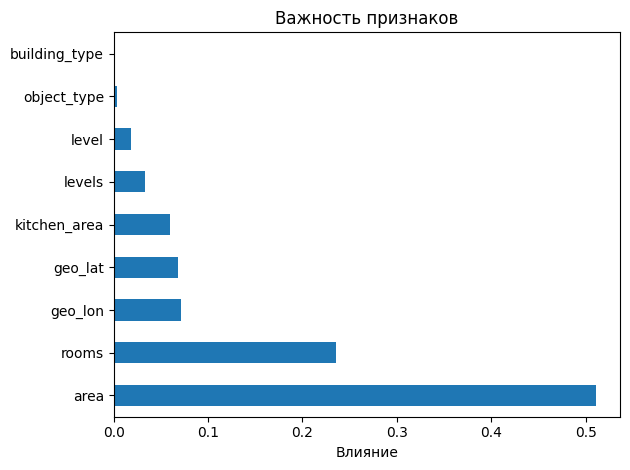

In [26]:
pd.Series(model.featureImportances.toArray(), index=feature_cols).sort_values(ascending=False).plot(kind='barh')
plt.title("Важность признаков")
plt.xlabel("Влияние")
plt.tight_layout()
plt.show()